#  CM50265 Machine Learning 2

## Coursework 2: Deep learning
### Youssef Alami Mejjati, Jordan Taylor, Jake Deane and Mohammad Golbabaee


This coursework is worth 75 points from the overall mark of 100 for this unit. Marks are given beside each task. The report will be your main method of assessment. __Students should form groups of 3 individuals and submit one report per group.__ For this coursework students can choose their partners until __20th February__.  Each group will receive a total mark for this course work and individuals in that group will share this mark (with weights) according to their contributions.  

- The __submission deadline__ for your report is
__17th May 2020, 12:00: online Moodle submission of your final report__

The main part of your report should not exceed __3000 word limit__. After the main part please attach a Table of individuals’ contributions and appendices including ONLY the codes (these are excluded from the word limit). The report should be submitted in PDF format. __Table of contributions__ should include both students’ names/university IDs, the list of contributions of each student, and finally the contribution percentage for each student. This percentage should be agreed between both individuals and it will be used to weigh their marks. We highly encourage individuals to evenly share the workload. Further, you should __include all codes__ relevant to your implementations as an appendix or appendices with a clear referencing to the main body of your report. Codes must be well commented (indicating major steps).

First and foremost your report should demonstrate and evaluate your results. It must include figures and screenshots with appropriate resolutions. Evaluation can be qualitative (how it looks) and, wherever possible, quantitative (tested numerically). Second you should provide evidence that you understood the mathematics behind the assignment in each task/question. You should concisely explain your approach to solve each task/question, and the choices you make (e.g. hyper-parameters etc) for each part.

Usual university rules apply, please check your MSc program handbook, particularly regarding plagiarism and delayed deliveries. 

__Note:__ All tasks should be implemented in TensorFlow. Guidelines below (tasks 3-5, 7) should work for a TensorFlow version 1. If you use TF v2 please note that some syntaxes have changed during the recent update, but you can still use version compatiblity to resolve the issue. The list includes but might not be limited to:

tf.layers.conv2d -> tf.nn.conv2d

tf.layers.dense -> tf.nn.dense

tf.layers.flatten -> tf.compat.v1.layers.flatten

tf.variable_scope -> tf.compat.v1.variable_scope

tf.get_collection -> tf.compat.v1.get_collection

similarly for tf.compat.v1.InteractiveSession, tf.compat.v1.train.AdamOptimizer, tf.compat.v1.placeholder, tf.compat.v1.global_variables_initializer, tf.compat.v1.local_variables_initializer, tf.compat.v1.train.Saver, tf.compat.v1.summary.FileWriter, tf.compat.v1.trainable_variables

See TF web documentation in case you encounter version incompatibility. 

Guides on tasks 6 and 8 should be already compatible with TF2. 


## The coursework 


In [1]:
import warnings
import time
warnings.filterwarnings('ignore')
import tensorflow as tf # This may laod Tensorflow 2.0.0 if that is the verison of the package on your distribution
#use import tensorflow.compat.v1 as tf for tensorflow 1
# tf.disable_v2_behaviour() # Only needed if using tensorflow 1 with tensorflow 2 being the package avlaiable  
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
from sklearn import preprocessing
from sklearn.decomposition import PCA
%matplotlib inline



In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

We scale the data to be in $[-1,1]$.

In [3]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

The size of each data points is $28 \times 28$. While this format will be useful when using CNNs, we will vectorize the datapoints for visualization and preliminary questions.

In [4]:
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

print(x_train.shape)
print(x_train)
m = np.amax(x_train)
print(m)
print(y_train)

ymax = np.amax(y_train)
ymin = np.amin(y_train)

print(ymax)
print(ymin)

(60000, 784)
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
1.0
[5 0 4 ... 5 6 8]
9
0


### 1. Data visualisation (5 points)
Project the training data points in a 2D space using PCA. Use the obtained 2D embedding and plot the training data-points with different markers or colors for each class (you are allowed to use PCA from scikit learn). 
- Why PCA is a good option to visualize data? 
- Add this plot in your report and discuss your observations. 
- Which classes can be linearly separated?


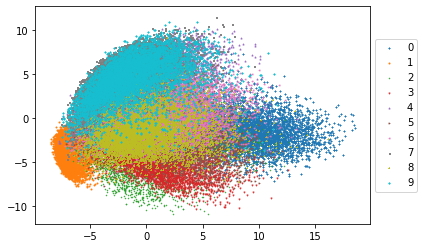

In [5]:
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x_train)

markers = ['x','o','.','v','^','>','<','s','+','D']

for i in range(0,10):
    
    plt.scatter(x_reduced[y_train==i][:,0], x_reduced[y_train==i][:,1], label=str(i), marker=markers[i], s=1)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### 2. Perceptrons: (10 points)
Single Layer Perceptron is one of the most basic binary classifiers one can use. In this part of the CW you should implement an iterative algorithm for training the Single Layer Perceptron.

As we are dealing with a binary classification problem, we will pick data points corresponding to classes 0 and 1 (handwritten digits). In addition we choose our binary labels to be -1 and 1, respectively.

In [6]:
cond = (y_train == 0) + (y_train == 1)
binary_x_train = x_train[cond,:]
binary_y_train = y_train[cond]*1.

cond = (y_test == 0) + (y_test == 1)
binary_x_test = x_test[cond,:]
binary_y_test = y_test[cond]*1.


In [7]:
binary_y_train[binary_y_train == 0] = -1
binary_y_train[binary_y_train == 1] = 1

binary_y_test[binary_y_test == 0] = -1
binary_y_test[binary_y_test == 1] = 1

#### Task 2.1
Complete the function 'predict' below.
#### inputs:

+ $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
+ $w \in\mathbb{R^m}$ is the parameter vector we wish to learn. 
+ $b \in\mathbb{R}$ is the corresponding bias.

#### outputs: 
+ 'prediction'$\in\mathbb{R^n}$, a vector containing prediction values associated with $x$. 

In [8]:
def predict(x, w, b):
    ######### Complete the function- x point ######### 
    #x = np.transpose(x)
    mmult = np.dot(w,x)
    prediction = np.sign(mmult + b)

    ######################################
    return prediction

#### Task 2.2
+ Use the funtion 'predict' above to implement the Single Layer Perceptron algorithm by completing the function 'optimize' defined below.
    #### inputs:

    + $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
    + $w \in\mathbb{R^m}$ is the initial parameter vector.
    + $b \in\mathbb{R}$ is the initial bias value.
    + $y\in\mathbb{R^n}$ is the training labels associated with x.
    #### outputs:
    + $w$ is the optimized parameter vector.
    + $b$ the corresponding learned bias.
    + $\text{error}$ is the classification error obtained.  
    
    
 
    
Use the learned parameters $w$, $b$ (obtained via function 'optimize') and the function 'predict' to return the classification accuracy on the test set using x_train and y_train as training data. 

- Demonstrate that your algorithm converges to a good local minima. Plot the training error curve vs. number of iterations. 
- Show what feature $w$ has learned and discuss why? (demonstrate $w$ as an image with the same size as inputs).

- Repeat this training/testing procedure to classify different pairs. Report the accuracies of 5 pairs in a Table and dicuss why some are easier to classify than others.


In [9]:
def optimize(x, y,iters=1000):
    iter = 0
    loss = 0    
    error=np.inf
    n, m = x.shape
    w = np.random.rand(m) # Initialize the w vector
    b = np.random.rand()  # Initialize the b vector

    lr = 0.005 # learning rate
    
    while (iter <= iters) & (error > 1e-3):
        ######### Complete the function- x points ######### 
        idx = np.random.choice(np.arange(len(x)))
        x_sample = x[idx]
        y_sample = y[idx]

        pred = predict(x_sample,w,b)
        
        if pred != y_sample:
            w = w + (lr*(y_sample*x_sample))
            
        iter+=1
    
    for itm in np.arange(len(x)):
        
        pred = predict(x[itm],w,b)
        
        if pred != y[itm]:
            loss+=1
            
        error = loss/len(y)
            
    #print('W: ',w)
    #print('B: ',b)
    #print('Training error: ',error)
    
    return w, b, error

In [10]:
#the_w, the_b, training_error = optimize(binary_x_train, binary_y_train)
errs = []
errs_test = []
'''
for i in range(1,1000):
    the_w, the_b, training_error = optimize(binary_x_train, binary_y_train, iters=i)
    errs.append(training_error)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,1000), errs)
ax.set_xlabel('Iter')
ax.set_ylabel('Loss') 
plt.title('Training Error')

for i in range(1,1000):
    the_w, the_b, training_error = optimize(binary_x_test, binary_y_test, iters=i)
    errs_test.append(training_error)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,1000), errs_test)
ax.set_xlabel('Iter')
ax.set_ylabel('Loss') 
plt.title('Test Error')

item = np.random.choice(np.arange(len(binary_y_test)))
pred = predict(binary_x_test[item,:], the_w, the_b)
print(binary_y_test[item])
print(pred)
fig = plt.figure()
img = binary_x_test[item,:].reshape(28,28)
imgplot = plt.imshow(img, cmap='gray')
'''


"\nfor i in range(1,1000):\n    the_w, the_b, training_error = optimize(binary_x_train, binary_y_train, iters=i)\n    errs.append(training_error)\n    \nfig = plt.figure()\nax = fig.add_subplot(111)\nax.plot(range(1,1000), errs)\nax.set_xlabel('Iter')\nax.set_ylabel('Loss') \nplt.title('Training Error')\n\nfor i in range(1,1000):\n    the_w, the_b, training_error = optimize(binary_x_test, binary_y_test, iters=i)\n    errs_test.append(training_error)\n    \nfig = plt.figure()\nax = fig.add_subplot(111)\nax.plot(range(1,1000), errs_test)\nax.set_xlabel('Iter')\nax.set_ylabel('Loss') \nplt.title('Test Error')\n\nitem = np.random.choice(np.arange(len(binary_y_test)))\npred = predict(binary_x_test[item,:], the_w, the_b)\nprint(binary_y_test[item])\nprint(pred)\nfig = plt.figure()\nimg = binary_x_test[item,:].reshape(28,28)\nimgplot = plt.imshow(img, cmap='gray')\n"

### 3: Multi Layer Perceptron (10 points)

Multi Layer Perceptron (MLP) is a fully connected deep (more than one hidden layer) network. In this part of the coursework we will implement a 2 hidden layers MLP with Recified Linear Unit (ReLU) activations. We will train the model via ADAM optimizer over a cross-entropy loss function.

First of all, we will convert our label vectors to matrices via one-hot encoding (e.g. $y=2$ would become $[0,0,1,0,0,0,0,0,0,0]$). This can be simply done using commands below:

In [11]:
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

Below, we define a class MLP. It is initialized via:  

+ x_train: The training matrix.
+ y_train: One hot encoding of the corresponding labels.
+ lr: Learning rate used for ADAM optimizer
+ nb_epochs: Number of epochs to use
+ batch_size: The number of data point in each mini-batch
+ output_dir: The directory where model parameters and tensorboard event files will be stored.

We also define the methods: 
* 'create_model' which will desribe a neural network architecture of the form $[784, 1000, 1000, 10]$, each integer representing the number of neurons in a given layer while the length of the vector defines the number of layers accordingly. 
* 'compute_loss' which given the output of 'create_model' will calculate the cross-entropy loss of the mini-batches.
* 'train' where we initiate a tensorflow session and perform the training iterations. 
* 'test' where we load our trained model and perform inference on the test set.

##### Task 3.1
- Complete the method 'create_model' in order to implement a network of the shape $[784, 1000, 1000, 10]$, use ReLU as the non linear activation for hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output __<font color='red'>without activation of the MLP.</font>__
   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
- You may use tf.layers.dense to implement a fully connected layer. 
- To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [12]:
class MLP:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self, config):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
        ######### Complete the function ######### 
        
            inputL = tf.layers.dense(inputs=self.im, units=784, activation=tf.nn.relu, name='inp_'+str(config[0]))  
        
            if(config[0] == 0):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=1000, activation=tf.nn.relu, name='h2_'+str(config[0])) 
                self.logits = tf.layers.dense(inputs=hidden2, units=10, name='lg_'+str(config[0]))                 
            
            if(config[0] == 1):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=1000, activation=tf.nn.relu, name='h2_'+str(config[0]))  
                hidden3 = tf.layers.dense(inputs=hidden2, units=1000, activation=tf.nn.relu, name='h3_'+str(config[0]))                
                self.logits = tf.layers.dense(inputs=hidden3, units=10, name='lg_'+str(config[0]))   
                
            if(config[0] == 2):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=500, activation=tf.nn.relu, name='h2_'+str(config[0]))  
                hidden3 = tf.layers.dense(inputs=hidden2, units=100, activation=tf.nn.relu, name='h3_'+str(config[0]))                
                self.logits = tf.layers.dense(inputs=hidden3, units=10, name='lg_'+str(config[0]))     
                
            if(config[0] == 3):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=2000, activation=tf.nn.relu, name='h2_'+str(config[0]))  
                hidden3 = tf.layers.dense(inputs=hidden2, units=3000, activation=tf.nn.relu, name='h3_'+str(config[0]))  
                hidden4 = tf.layers.dense(inputs=hidden3, units=3000, activation=tf.nn.relu, name='h4_'+str(config[0]))                 
                hidden5 = tf.layers.dense(inputs=hidden4, units=3000, activation=tf.nn.relu, name='h5_'+str(config[0]))                 
                self.logits = tf.layers.dense(inputs=hidden5, units=10, name='lg_'+str(config[0]))                 
                
            if(config[0] == 4):

                hidden1 = tf.layers.dense(inputs=inputL, units=512, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=256, activation=tf.nn.relu, name='h2_'+str(config[0]))  
                hidden3 = tf.layers.dense(inputs=hidden2, units=128, activation=tf.nn.relu, name='h3_'+str(config[0]))  
                hidden4 = tf.layers.dense(inputs=hidden3, units=64, activation=tf.nn.relu, name='h4_'+str(config[0]))                 
                hidden5 = tf.layers.dense(inputs=hidden4, units=32, activation=tf.nn.relu, name='h5_'+str(config[0]))                 
                self.logits = tf.layers.dense(inputs=hidden5, units=10, name='lg_'+str(config[0]))                    
            
            self.preds = tf.nn.softmax(self.logits)           

    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)
            
    def getComplexity(self):
        total_parameters = 0
        for variable in tf.trainable_variables():
            # shape is an array of tf.Dimension
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim.value
            total_parameters += variable_parameters
        self.compx = tf.constant(total_parameters)         

Now that we defined our model, our loss and its optimizer. we can instantate the MLP class, initiate our variables, and start the tensorflow session:

In [13]:
model = MLP(x_train, y_train, './MLP_logdir/', 0.001, 2, 10)
model.create_model([0])
model.compute_loss()
model.optimizer()
model.getComplexity()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We can now start training. We loop over the training data points and we feed them to the session in mini-batches form. we repeat this process several times (for several epochs). 

In [14]:
startT = time.time()
for epoch in range(model.nb_epochs):
    #print('Epoch: ',epoch)
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        #print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()
timeTaken = int(time.time() - startT)

During and after training visualize the training and the created graph via tensorboard. Tensorboard is accessible via the command "tensorboard --logdir=#yourlogdir#". Check out https://www.tensorflow.org/guide/summaries_and_tensorboard for more details.

Similarly we loop over the test dataset and get the test accuracy via:

In [15]:
perfs = []
complexities = []
duration = [timeTaken]

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds,
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
        
complexity = sess.run(model.compx)
complexities.append(complexity)

all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
perfs.append(acc_test)
print('Test accuracy achieved: %.3f' %acc_test)

Test accuracy achieved: 0.940



- Include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report.


We now close the tensorflow session:

In [16]:
sess.close()

##### Task 3.2
Using a similar format as before, discuss how the number of layers affects the classification accuracy. 
- Train four different networks with more hidden layers for example 3,4,5 and 7 hidden layers (choice is yours here to make a good conclusion). Choose an appropriate width i.e. number of neurons per layer so to achieve good accuracy and feasible training time. How many paramters (weights/biases) do these models have? How do they compare to the former MLP you implemented? 
- Compare the classification accuracies of these networks with the previous MLP.


- Plot a graph showing the accuracy vs. depth v.s. complexity (number of paramters) of the all five MLPs with different depths/widths. Additionally report the results in a Table. Discuss the results and provide conclusion. 


In [17]:
for nets in range(1,5):
    
    model = MLP(x_train, y_train, './MLP_logdir_'+(str(nets))+'/', 0.001, 2, 10)
    model.create_model([nets])
    model.compute_loss()
    model.optimizer()
    model.getComplexity()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)
        
    startT = time.time()    
    for epoch in range(model.nb_epochs):
        #print('Epoch: ',epoch)
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            #print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)
        
    timeTaken = int(time.time() - startT)
    duration.append(timeTaken) 
    
    batch_size_test = 20
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))
            
    complexity = sess.run(model.compx)
    complexities.append(complexity)            
            
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    perfs.append(acc_test)        
        
    sess.close()


In [18]:
print(perfs)
print(complexities)
print(duration)

[0.9396, 0.9317, 0.9246, 0.9337, 0.9578]
[2411450, 5823900, 7775950, 35217400, 36409650]
[115, 152, 100, 1231, 65]


### 4. Convolutional Neural Network (10 points)
Now that we are more familiar with the MLP algorithm, it is time to see how it compares with a Convolutional Neural Network (CNN). CNNs leverage dependencies between neighbouring pixels, making them more efficient and light weight compared to their fully connected counter part. In this section we will implement a Class CNN similar to the one we defined before for MLP.

##### Task 4.1
Complete the function 'create_model' of the class CNN above. Implement a CNN of the shape [32, 64, 128]; where 32, 64, 128 represent the number of convolutional filters for each hidden layer. We will use a kernel size of size $4\times4$. 

Use a stride of 1 in the first convolutional layer, followed by a stride of 2 for the following layers (a stride of two help downsampling without requiring the use of pooling layers). Vectorize the obtained output using tf.layer.flatten, and end the model with a fully connected layer of 10 neurons. Use ReLU as the non linear activation for the hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 

   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
+ You may use tf.layers.conv2d to implement a convolutional layer. 
+ To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [19]:
class CNN:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            ######### Complete the function #########
            
            inputL = tf.layers.conv2d(inputs=self.im, filters=32, strides=1, kernel_size=[4,4], activation=tf.nn.relu)
            conv1 = tf.layers.conv2d(inputs=self.im, filters=64, strides=2, kernel_size=[4,4], activation=tf.nn.relu)
            conv2 = tf.layers.conv2d(inputs=self.im, filters=128, strides=2, kernel_size=[4,4], activation=tf.nn.relu)
            flatten = tf.layers.flatten(conv2)
            self.logits = tf.layers.dense(inputs=flatten, units=10) 
            self.preds = tf.nn.softmax(self.logits)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

CNNs leverage dependencies between neighbouring pixels, however this information is partially lost when we vectorized our data. For training CNNs we will need to recover our initial shape of $N \times 28 \times 28$.

In [20]:
edge = int(np.sqrt(nb_features))
x_train.resize([n_train, edge, edge])
x_test.resize([n_test, edge, edge])

We instantiate our CNN class, start the corresponging tensorflow session and initiate the trainable variables. 

In [21]:
model = CNN(x_train, y_train, './CNN_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.flatten instead.


We start training:

In [22]:
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

Epoch 0, Iteration 0, loss 2.379, batch accuracy 0.000
Epoch 0, Iteration 1, loss 2.768, batch accuracy 0.000
Epoch 0, Iteration 2, loss 2.329, batch accuracy 0.200
Epoch 0, Iteration 3, loss 2.188, batch accuracy 0.000
Epoch 0, Iteration 4, loss 2.596, batch accuracy 0.200
Epoch 0, Iteration 5, loss 2.035, batch accuracy 0.600
Epoch 0, Iteration 6, loss 1.898, batch accuracy 0.600
Epoch 0, Iteration 7, loss 1.863, batch accuracy 0.500
Epoch 0, Iteration 8, loss 1.572, batch accuracy 0.700
Epoch 0, Iteration 9, loss 2.059, batch accuracy 0.200
Epoch 0, Iteration 10, loss 1.523, batch accuracy 0.700
Epoch 0, Iteration 11, loss 1.941, batch accuracy 0.300
Epoch 0, Iteration 12, loss 1.168, batch accuracy 0.700
Epoch 0, Iteration 13, loss 1.716, batch accuracy 0.600
Epoch 0, Iteration 14, loss 1.542, batch accuracy 0.400
Epoch 0, Iteration 15, loss 1.880, batch accuracy 0.200
Epoch 0, Iteration 16, loss 1.335, batch accuracy 0.700
Epoch 0, Iteration 17, loss 1.175, batch accuracy 0.700
Ep

Epoch 0, Iteration 175, loss 0.172, batch accuracy 1.000
Epoch 0, Iteration 176, loss 0.192, batch accuracy 1.000
Epoch 0, Iteration 177, loss 0.658, batch accuracy 0.800
Epoch 0, Iteration 178, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 179, loss 0.496, batch accuracy 0.700
Epoch 0, Iteration 180, loss 0.693, batch accuracy 0.800
Epoch 0, Iteration 181, loss 0.256, batch accuracy 0.800
Epoch 0, Iteration 182, loss 1.120, batch accuracy 0.800
Epoch 0, Iteration 183, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 184, loss 0.199, batch accuracy 1.000
Epoch 0, Iteration 185, loss 0.103, batch accuracy 1.000
Epoch 0, Iteration 186, loss 0.232, batch accuracy 1.000
Epoch 0, Iteration 187, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 188, loss 0.293, batch accuracy 0.900
Epoch 0, Iteration 189, loss 0.116, batch accuracy 1.000
Epoch 0, Iteration 190, loss 0.696, batch accuracy 0.800
Epoch 0, Iteration 191, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 192, loss 0.

Epoch 0, Iteration 350, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 351, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 352, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 353, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 354, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 355, loss 1.140, batch accuracy 0.800
Epoch 0, Iteration 356, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 357, loss 0.339, batch accuracy 0.800
Epoch 0, Iteration 358, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 359, loss 0.445, batch accuracy 0.900
Epoch 0, Iteration 360, loss 0.487, batch accuracy 0.900
Epoch 0, Iteration 361, loss 0.164, batch accuracy 0.900
Epoch 0, Iteration 362, loss 0.154, batch accuracy 1.000
Epoch 0, Iteration 363, loss 0.361, batch accuracy 0.900
Epoch 0, Iteration 364, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 365, loss 0.563, batch accuracy 0.800
Epoch 0, Iteration 366, loss 0.493, batch accuracy 0.800
Epoch 0, Iteration 367, loss 0.

Epoch 0, Iteration 523, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 524, loss 0.300, batch accuracy 0.800
Epoch 0, Iteration 525, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 526, loss 0.185, batch accuracy 1.000
Epoch 0, Iteration 527, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 528, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 529, loss 0.114, batch accuracy 0.900
Epoch 0, Iteration 530, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 531, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 532, loss 0.464, batch accuracy 0.900
Epoch 0, Iteration 533, loss 0.873, batch accuracy 0.900
Epoch 0, Iteration 534, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 535, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 536, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 537, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 538, loss 0.537, batch accuracy 0.700
Epoch 0, Iteration 539, loss 0.444, batch accuracy 0.800
Epoch 0, Iteration 540, loss 0.

Epoch 0, Iteration 698, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 699, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 700, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 701, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 702, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 703, loss 0.288, batch accuracy 0.900
Epoch 0, Iteration 704, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 705, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 706, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 707, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 708, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 709, loss 0.116, batch accuracy 1.000
Epoch 0, Iteration 710, loss 0.780, batch accuracy 0.900
Epoch 0, Iteration 711, loss 0.128, batch accuracy 0.900
Epoch 0, Iteration 712, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 713, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 714, loss 0.287, batch accuracy 0.900
Epoch 0, Iteration 715, loss 0.

Epoch 0, Iteration 874, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 875, loss 0.118, batch accuracy 0.900
Epoch 0, Iteration 876, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 877, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 878, loss 0.199, batch accuracy 0.900
Epoch 0, Iteration 879, loss 0.581, batch accuracy 0.900
Epoch 0, Iteration 880, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 881, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 882, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 883, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 884, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 885, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 886, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 887, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 888, loss 0.429, batch accuracy 0.800
Epoch 0, Iteration 889, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 890, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 891, loss 0.

Epoch 0, Iteration 1050, loss 1.352, batch accuracy 0.700
Epoch 0, Iteration 1051, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 1052, loss 0.147, batch accuracy 0.900
Epoch 0, Iteration 1053, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 1054, loss 0.250, batch accuracy 0.900
Epoch 0, Iteration 1055, loss 0.171, batch accuracy 0.800
Epoch 0, Iteration 1056, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 1057, loss 0.360, batch accuracy 0.900
Epoch 0, Iteration 1058, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 1059, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 1060, loss 0.147, batch accuracy 0.900
Epoch 0, Iteration 1061, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 1062, loss 0.596, batch accuracy 0.900
Epoch 0, Iteration 1063, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 1064, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 1065, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 1066, loss 0.175, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1226, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 1227, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 1228, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 1229, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 1230, loss 0.491, batch accuracy 0.900
Epoch 0, Iteration 1231, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 1232, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 1233, loss 0.206, batch accuracy 1.000
Epoch 0, Iteration 1234, loss 0.079, batch accuracy 0.900
Epoch 0, Iteration 1235, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 1236, loss 0.400, batch accuracy 0.900
Epoch 0, Iteration 1237, loss 0.415, batch accuracy 0.800
Epoch 0, Iteration 1238, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 1239, loss 1.181, batch accuracy 0.700
Epoch 0, Iteration 1240, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 1241, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 1242, loss 0.171, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1401, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 1402, loss 0.618, batch accuracy 0.900
Epoch 0, Iteration 1403, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 1404, loss 0.510, batch accuracy 0.900
Epoch 0, Iteration 1405, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 1406, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 1407, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 1408, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 1409, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 1410, loss 0.375, batch accuracy 0.900
Epoch 0, Iteration 1411, loss 0.260, batch accuracy 0.900
Epoch 0, Iteration 1412, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 1413, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 1414, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 1415, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 1416, loss 0.169, batch accuracy 0.900
Epoch 0, Iteration 1417, loss 0.023, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1576, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 1577, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 1578, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 1579, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 1580, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 1581, loss 0.103, batch accuracy 1.000
Epoch 0, Iteration 1582, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 1583, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 1584, loss 0.118, batch accuracy 0.900
Epoch 0, Iteration 1585, loss 0.269, batch accuracy 0.900
Epoch 0, Iteration 1586, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 1587, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 1588, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 1589, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 1590, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 1591, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 1592, loss 0.144, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1752, loss 0.494, batch accuracy 0.900
Epoch 0, Iteration 1753, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 1754, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 1755, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 1756, loss 0.360, batch accuracy 0.900
Epoch 0, Iteration 1757, loss 0.146, batch accuracy 0.900
Epoch 0, Iteration 1758, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 1759, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 1760, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 1761, loss 0.271, batch accuracy 0.900
Epoch 0, Iteration 1762, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 1763, loss 0.109, batch accuracy 0.900
Epoch 0, Iteration 1764, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 1765, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 1766, loss 0.312, batch accuracy 0.900
Epoch 0, Iteration 1767, loss 0.085, batch accuracy 0.900
Epoch 0, Iteration 1768, loss 1.474, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1926, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 1927, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 1928, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 1929, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 1930, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 1931, loss 0.126, batch accuracy 1.000
Epoch 0, Iteration 1932, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 1933, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 1934, loss 0.134, batch accuracy 1.000
Epoch 0, Iteration 1935, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 1936, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 1937, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 1938, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 1939, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 1940, loss 0.455, batch accuracy 0.800
Epoch 0, Iteration 1941, loss 0.187, batch accuracy 0.900
Epoch 0, Iteration 1942, loss 0.015, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2097, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 2098, loss 0.576, batch accuracy 0.800
Epoch 0, Iteration 2099, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 2100, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 2101, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 2102, loss 0.176, batch accuracy 0.900
Epoch 0, Iteration 2103, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 2104, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 2105, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 2106, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2107, loss 0.199, batch accuracy 0.900
Epoch 0, Iteration 2108, loss 0.124, batch accuracy 0.900
Epoch 0, Iteration 2109, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 2110, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 2111, loss 0.302, batch accuracy 0.900
Epoch 0, Iteration 2112, loss 0.123, batch accuracy 0.900
Epoch 0, Iteration 2113, loss 0.016, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2273, loss 0.343, batch accuracy 0.800
Epoch 0, Iteration 2274, loss 0.141, batch accuracy 0.900
Epoch 0, Iteration 2275, loss 0.849, batch accuracy 0.800
Epoch 0, Iteration 2276, loss 0.194, batch accuracy 0.900
Epoch 0, Iteration 2277, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 2278, loss 0.121, batch accuracy 0.900
Epoch 0, Iteration 2279, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2280, loss 0.426, batch accuracy 0.900
Epoch 0, Iteration 2281, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 2282, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 2283, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 2284, loss 0.357, batch accuracy 0.900
Epoch 0, Iteration 2285, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 2286, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 2287, loss 0.194, batch accuracy 0.900
Epoch 0, Iteration 2288, loss 0.476, batch accuracy 0.900
Epoch 0, Iteration 2289, loss 0.010, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2447, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 2448, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 2449, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 2450, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 2451, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 2452, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 2453, loss 0.383, batch accuracy 0.800
Epoch 0, Iteration 2454, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 2455, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2456, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 2457, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 2458, loss 0.212, batch accuracy 0.900
Epoch 0, Iteration 2459, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 2460, loss 0.162, batch accuracy 1.000
Epoch 0, Iteration 2461, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 2462, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 2463, loss 0.004, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2625, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 2626, loss 0.166, batch accuracy 0.900
Epoch 0, Iteration 2627, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 2628, loss 0.604, batch accuracy 0.900
Epoch 0, Iteration 2629, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 2630, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 2631, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 2632, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 2633, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 2634, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 2635, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 2636, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 2637, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 2638, loss 0.476, batch accuracy 0.900
Epoch 0, Iteration 2639, loss 0.080, batch accuracy 0.900
Epoch 0, Iteration 2640, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 2641, loss 0.008, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2804, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 2805, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 2806, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 2807, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 2808, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 2809, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 2810, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 2811, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 2812, loss 0.358, batch accuracy 0.900
Epoch 0, Iteration 2813, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 2814, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 2815, loss 0.083, batch accuracy 0.900
Epoch 0, Iteration 2816, loss 0.184, batch accuracy 0.900
Epoch 0, Iteration 2817, loss 0.120, batch accuracy 0.900
Epoch 0, Iteration 2818, loss 0.393, batch accuracy 0.800
Epoch 0, Iteration 2819, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 2820, loss 0.039, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2983, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 2984, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 2985, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 2986, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 2987, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 2988, loss 0.594, batch accuracy 0.800
Epoch 0, Iteration 2989, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2990, loss 0.147, batch accuracy 0.900
Epoch 0, Iteration 2991, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 2992, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 2993, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 2994, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 2995, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 2996, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 2997, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 2998, loss 0.140, batch accuracy 1.000
Epoch 0, Iteration 2999, loss 0.214, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3162, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 3163, loss 0.282, batch accuracy 0.900
Epoch 0, Iteration 3164, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 3165, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3166, loss 0.284, batch accuracy 0.900
Epoch 0, Iteration 3167, loss 0.146, batch accuracy 0.900
Epoch 0, Iteration 3168, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 3169, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 3170, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 3171, loss 0.092, batch accuracy 0.900
Epoch 0, Iteration 3172, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 3173, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 3174, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3175, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3176, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3177, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3178, loss 0.123, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3342, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 3343, loss 0.580, batch accuracy 0.900
Epoch 0, Iteration 3344, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 3345, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3346, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 3347, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3348, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 3349, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 3350, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3351, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 3352, loss 0.113, batch accuracy 0.900
Epoch 0, Iteration 3353, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 3354, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 3355, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 3356, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 3357, loss 0.083, batch accuracy 0.900
Epoch 0, Iteration 3358, loss 0.577, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3517, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 3518, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3519, loss 1.751, batch accuracy 0.900
Epoch 0, Iteration 3520, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 3521, loss 0.092, batch accuracy 0.900
Epoch 0, Iteration 3522, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 3523, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 3524, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 3525, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 3526, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 3527, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3528, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3529, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 3530, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 3531, loss 0.092, batch accuracy 0.900
Epoch 0, Iteration 3532, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 3533, loss 0.022, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3697, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 3698, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 3699, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3700, loss 0.286, batch accuracy 0.900
Epoch 0, Iteration 3701, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 3702, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 3703, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3704, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 3705, loss 0.517, batch accuracy 0.900
Epoch 0, Iteration 3706, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3707, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 3708, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 3709, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 3710, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3711, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 3712, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 3713, loss 0.226, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3884, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3885, loss 0.175, batch accuracy 0.900
Epoch 0, Iteration 3886, loss 0.121, batch accuracy 0.900
Epoch 0, Iteration 3887, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 3888, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 3889, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 3890, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 3891, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 3892, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 3893, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 3894, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 3895, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3896, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 3897, loss 1.075, batch accuracy 0.900
Epoch 0, Iteration 3898, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 3899, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 3900, loss 0.038, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4062, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 4063, loss 0.126, batch accuracy 0.900
Epoch 0, Iteration 4064, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4065, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 4066, loss 0.295, batch accuracy 0.900
Epoch 0, Iteration 4067, loss 0.165, batch accuracy 1.000
Epoch 0, Iteration 4068, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 4069, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4070, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 4071, loss 0.104, batch accuracy 0.900
Epoch 0, Iteration 4072, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4073, loss 0.092, batch accuracy 0.900
Epoch 0, Iteration 4074, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4075, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4076, loss 0.266, batch accuracy 0.800
Epoch 0, Iteration 4077, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4078, loss 0.508, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4240, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 4241, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 4242, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 4243, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4244, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4245, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4246, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4247, loss 0.077, batch accuracy 0.900
Epoch 0, Iteration 4248, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 4249, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 4250, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 4251, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4252, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4253, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4254, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4255, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 4256, loss 0.004, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4419, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 4420, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 4421, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4422, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 4423, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4424, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 4425, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4426, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 4427, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 4428, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 4429, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 4430, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 4431, loss 0.186, batch accuracy 0.900
Epoch 0, Iteration 4432, loss 0.991, batch accuracy 0.900
Epoch 0, Iteration 4433, loss 0.808, batch accuracy 0.900
Epoch 0, Iteration 4434, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 4435, loss 0.011, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4598, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 4599, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4600, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 4601, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4602, loss 0.429, batch accuracy 0.900
Epoch 0, Iteration 4603, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4604, loss 0.936, batch accuracy 0.900
Epoch 0, Iteration 4605, loss 0.099, batch accuracy 0.900
Epoch 0, Iteration 4606, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 4607, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 4608, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4609, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 4610, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 4611, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 4612, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4613, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 4614, loss 0.017, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4778, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 4779, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 4780, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 4781, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 4782, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4783, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4784, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 4785, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 4786, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4787, loss 0.452, batch accuracy 0.900
Epoch 0, Iteration 4788, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4789, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 4790, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 4791, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 4792, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 4793, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 4794, loss 0.401, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4953, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4954, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4955, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4956, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 4957, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 4958, loss 0.186, batch accuracy 0.900
Epoch 0, Iteration 4959, loss 0.208, batch accuracy 0.800
Epoch 0, Iteration 4960, loss 0.315, batch accuracy 0.900
Epoch 0, Iteration 4961, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4962, loss 0.659, batch accuracy 0.900
Epoch 0, Iteration 4963, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 4964, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4965, loss 0.335, batch accuracy 0.900
Epoch 0, Iteration 4966, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4967, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 4968, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 4969, loss 0.002, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5128, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 5129, loss 0.149, batch accuracy 0.900
Epoch 0, Iteration 5130, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5131, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 5132, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5133, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5134, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 5135, loss 0.503, batch accuracy 0.900
Epoch 0, Iteration 5136, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 5137, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5138, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 5139, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 5140, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5141, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5142, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 5143, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 5144, loss 0.020, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5309, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5310, loss 0.482, batch accuracy 0.900
Epoch 0, Iteration 5311, loss 1.269, batch accuracy 0.900
Epoch 0, Iteration 5312, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 5313, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 5314, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5315, loss 0.126, batch accuracy 0.900
Epoch 0, Iteration 5316, loss 0.123, batch accuracy 0.900
Epoch 0, Iteration 5317, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 5318, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 5319, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5320, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 5321, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 5322, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5323, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5324, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 5325, loss 0.011, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5485, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5486, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5487, loss 0.126, batch accuracy 0.900
Epoch 0, Iteration 5488, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 5489, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 5490, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 5491, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5492, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 5493, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 5494, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5495, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5496, loss 0.124, batch accuracy 0.900
Epoch 0, Iteration 5497, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 5498, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5499, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 5500, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5501, loss 0.432, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5666, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5667, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 5668, loss 0.202, batch accuracy 0.900
Epoch 0, Iteration 5669, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5670, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 5671, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5672, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5673, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5674, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5675, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 5676, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5677, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 5678, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 5679, loss 0.128, batch accuracy 0.900
Epoch 0, Iteration 5680, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 5681, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 5682, loss 0.020, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5842, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5843, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 5844, loss 0.419, batch accuracy 0.900
Epoch 0, Iteration 5845, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 5846, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 5847, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5848, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 5849, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5850, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 5851, loss 0.104, batch accuracy 0.900
Epoch 0, Iteration 5852, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5853, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5854, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5855, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5856, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5857, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 5858, loss 0.006, batch accuracy 1.000
Epoch 0, Itera

Epoch 1, Iteration 0, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2, loss 0.358, batch accuracy 0.700
Epoch 1, Iteration 3, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 4, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 6, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 7, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 8, loss 0.243, batch accuracy 0.900
Epoch 1, Iteration 9, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 10, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 11, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 12, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 13, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 14, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 15, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 16, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 17, loss 0.003, batch accuracy 1.000
Ep

Epoch 1, Iteration 179, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 180, loss 0.711, batch accuracy 0.900
Epoch 1, Iteration 181, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 182, loss 0.076, batch accuracy 0.900
Epoch 1, Iteration 183, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 184, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 185, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 186, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 187, loss 0.149, batch accuracy 0.900
Epoch 1, Iteration 188, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 189, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 190, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 191, loss 0.348, batch accuracy 0.900
Epoch 1, Iteration 192, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 193, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 194, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 195, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 196, loss 0.

Epoch 1, Iteration 360, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 361, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 362, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 363, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 364, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 365, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 366, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 367, loss 0.215, batch accuracy 0.900
Epoch 1, Iteration 368, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 369, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 370, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 371, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 372, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 373, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 374, loss 0.074, batch accuracy 0.900
Epoch 1, Iteration 375, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 376, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 377, loss 0.

Epoch 1, Iteration 542, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 543, loss 0.098, batch accuracy 0.900
Epoch 1, Iteration 544, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 545, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 546, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 547, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 548, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 549, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 550, loss 0.120, batch accuracy 0.900
Epoch 1, Iteration 551, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 552, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 553, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 554, loss 0.493, batch accuracy 0.900
Epoch 1, Iteration 555, loss 0.580, batch accuracy 0.900
Epoch 1, Iteration 556, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 557, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 558, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 559, loss 0.

Epoch 1, Iteration 718, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 719, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 720, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 721, loss 0.407, batch accuracy 0.900
Epoch 1, Iteration 722, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 723, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 724, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 725, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 726, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 727, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 728, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 729, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 730, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 731, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 732, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 733, loss 0.102, batch accuracy 0.900
Epoch 1, Iteration 734, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 735, loss 0.

Epoch 1, Iteration 899, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 900, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 901, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 902, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 903, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 904, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 905, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 906, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 907, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 908, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 909, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 910, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 911, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 912, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 913, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 914, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 915, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 916, loss 0.

Epoch 1, Iteration 1076, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1077, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1078, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1079, loss 0.622, batch accuracy 0.900
Epoch 1, Iteration 1080, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1081, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1082, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1083, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1084, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1085, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1086, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1087, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 1088, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 1089, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1090, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1091, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1092, loss 0.141, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1254, loss 0.269, batch accuracy 0.900
Epoch 1, Iteration 1255, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1256, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1257, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 1258, loss 0.240, batch accuracy 0.900
Epoch 1, Iteration 1259, loss 0.094, batch accuracy 0.900
Epoch 1, Iteration 1260, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 1261, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1262, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 1263, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1264, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1265, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1266, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1267, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1268, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1269, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 1270, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1426, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 1427, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1428, loss 0.151, batch accuracy 0.900
Epoch 1, Iteration 1429, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1430, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1431, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1432, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 1433, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1434, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1435, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1436, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1437, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1438, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1439, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1440, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1441, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1442, loss 0.021, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1593, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1594, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1595, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1596, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1597, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1598, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1599, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 1600, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1601, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1602, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1603, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 1604, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1605, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1606, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1607, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 1608, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1609, loss 0.434, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1763, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1764, loss 0.179, batch accuracy 0.900
Epoch 1, Iteration 1765, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1766, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1767, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1768, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 1769, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1770, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1771, loss 0.210, batch accuracy 0.900
Epoch 1, Iteration 1772, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 1773, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1774, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 1775, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1776, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 1777, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1778, loss 0.111, batch accuracy 1.000
Epoch 1, Iteration 1779, loss 0.089, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1938, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1939, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1940, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1941, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1942, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1943, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1944, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1945, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1946, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1947, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1948, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1949, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1950, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1951, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1952, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 1953, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1954, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2115, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2116, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2117, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2118, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2119, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2120, loss 0.495, batch accuracy 0.800
Epoch 1, Iteration 2121, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2122, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 2123, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2124, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2125, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2126, loss 0.795, batch accuracy 0.800
Epoch 1, Iteration 2127, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2128, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 2129, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2130, loss 1.184, batch accuracy 0.900
Epoch 1, Iteration 2131, loss 0.042, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2292, loss 0.208, batch accuracy 0.800
Epoch 1, Iteration 2293, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2294, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2295, loss 0.247, batch accuracy 0.900
Epoch 1, Iteration 2296, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2297, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 2298, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2299, loss 0.725, batch accuracy 0.800
Epoch 1, Iteration 2300, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 2301, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2302, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2303, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2304, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2305, loss 0.325, batch accuracy 0.900
Epoch 1, Iteration 2306, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2307, loss 0.170, batch accuracy 0.900
Epoch 1, Iteration 2308, loss 0.007, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2469, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2470, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 2471, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2472, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2473, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 2474, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2475, loss 0.391, batch accuracy 0.900
Epoch 1, Iteration 2476, loss 0.229, batch accuracy 0.900
Epoch 1, Iteration 2477, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2478, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2479, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2480, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 2481, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2482, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 2483, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2484, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2485, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2647, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2648, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2649, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 2650, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2651, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2652, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 2653, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 2654, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2655, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 2656, loss 0.095, batch accuracy 0.900
Epoch 1, Iteration 2657, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2658, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 2659, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 2660, loss 0.092, batch accuracy 0.900
Epoch 1, Iteration 2661, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 2662, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2663, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2825, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2826, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2827, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2828, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2829, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2830, loss 0.092, batch accuracy 0.900
Epoch 1, Iteration 2831, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 2832, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2833, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2834, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 2835, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 2836, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2837, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 2838, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2839, loss 0.134, batch accuracy 0.900
Epoch 1, Iteration 2840, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2841, loss 0.019, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2998, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2999, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 3000, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 3001, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3002, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 3003, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 3004, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 3005, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3006, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3007, loss 0.478, batch accuracy 0.900
Epoch 1, Iteration 3008, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3009, loss 0.190, batch accuracy 0.900
Epoch 1, Iteration 3010, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3011, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3012, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3013, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3014, loss 0.536, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3173, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3174, loss 0.469, batch accuracy 0.900
Epoch 1, Iteration 3175, loss 0.189, batch accuracy 0.900
Epoch 1, Iteration 3176, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 3177, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 3178, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3179, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3180, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 3181, loss 0.357, batch accuracy 0.900
Epoch 1, Iteration 3182, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3183, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3184, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3185, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 3186, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3187, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3188, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3189, loss 0.128, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3345, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3346, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3347, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3348, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3349, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3350, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3351, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3352, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3353, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3354, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 3355, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 3356, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 3357, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3358, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 3359, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 3360, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3361, loss 0.060, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3520, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3521, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3522, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3523, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3524, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 3525, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 3526, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 3527, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 3528, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3529, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3530, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3531, loss 0.137, batch accuracy 0.900
Epoch 1, Iteration 3532, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3533, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3534, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 3535, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3536, loss 0.003, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3685, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 3686, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 3687, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3688, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 3689, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3690, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3691, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3692, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3693, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3694, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3695, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3696, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3697, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3698, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3699, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3700, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 3701, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3873, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3874, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3875, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3876, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3877, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3878, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3879, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3880, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 3881, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 3882, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3883, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3884, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3885, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 3886, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3887, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3888, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 3889, loss 0.056, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4061, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 4062, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4063, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4064, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 4065, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 4066, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4067, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4068, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4069, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4070, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4071, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4072, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 4073, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4074, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4075, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4076, loss 0.135, batch accuracy 0.900
Epoch 1, Iteration 4077, loss 0.020, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4251, loss 0.118, batch accuracy 0.900
Epoch 1, Iteration 4252, loss 0.491, batch accuracy 0.900
Epoch 1, Iteration 4253, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 4254, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4255, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4256, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4257, loss 0.072, batch accuracy 0.900
Epoch 1, Iteration 4258, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4259, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4260, loss 0.618, batch accuracy 0.900
Epoch 1, Iteration 4261, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 4262, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4263, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4264, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 4265, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4266, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4267, loss 0.025, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4439, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 4440, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4441, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4442, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4443, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4444, loss 0.880, batch accuracy 0.900
Epoch 1, Iteration 4445, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4446, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 4447, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4448, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4449, loss 0.477, batch accuracy 0.600
Epoch 1, Iteration 4450, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 4451, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4452, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 4453, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 4454, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4455, loss 0.011, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4626, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4627, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4628, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4629, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 4630, loss 0.111, batch accuracy 0.900
Epoch 1, Iteration 4631, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4632, loss 0.381, batch accuracy 0.900
Epoch 1, Iteration 4633, loss 0.145, batch accuracy 0.900
Epoch 1, Iteration 4634, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4635, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 4636, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4637, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4638, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 4639, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4640, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 4641, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 4642, loss 0.005, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4816, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4817, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 4818, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 4819, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4820, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4821, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4822, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4823, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4824, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 4825, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4826, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4827, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4828, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4829, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 4830, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4831, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4832, loss 0.026, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5004, loss 0.136, batch accuracy 1.000
Epoch 1, Iteration 5005, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 5006, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5007, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5008, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5009, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5010, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 5011, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 5012, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5013, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5014, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5015, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5016, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 5017, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5018, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5019, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 5020, loss 0.033, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5190, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5191, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5192, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5193, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 5194, loss 0.119, batch accuracy 0.900
Epoch 1, Iteration 5195, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 5196, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5197, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5198, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5199, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 5200, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 5201, loss 0.223, batch accuracy 0.900
Epoch 1, Iteration 5202, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 5203, loss 0.159, batch accuracy 0.900
Epoch 1, Iteration 5204, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5205, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5206, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5379, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5380, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5381, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5382, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5383, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 5384, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5385, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5386, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 5387, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5388, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5389, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5390, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 5391, loss 0.314, batch accuracy 0.900
Epoch 1, Iteration 5392, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5393, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 5394, loss 0.367, batch accuracy 0.900
Epoch 1, Iteration 5395, loss 0.135, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5570, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5571, loss 0.075, batch accuracy 0.900
Epoch 1, Iteration 5572, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5573, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5574, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5575, loss 0.283, batch accuracy 0.900
Epoch 1, Iteration 5576, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5577, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5578, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5579, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5580, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5581, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5582, loss 0.600, batch accuracy 0.800
Epoch 1, Iteration 5583, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5584, loss 0.110, batch accuracy 0.900
Epoch 1, Iteration 5585, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5586, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5761, loss 0.088, batch accuracy 0.900
Epoch 1, Iteration 5762, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5763, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 5764, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5765, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5766, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5767, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 5768, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5769, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5770, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5771, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 5772, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5773, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5774, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5775, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 5776, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5777, loss 0.035, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5951, loss 0.089, batch accuracy 0.900
Epoch 1, Iteration 5952, loss 0.277, batch accuracy 0.900
Epoch 1, Iteration 5953, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5954, loss 0.351, batch accuracy 0.800
Epoch 1, Iteration 5955, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5956, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5957, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 5958, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5959, loss 0.333, batch accuracy 0.900
Epoch 1, Iteration 5960, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5961, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 5962, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5963, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5964, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5965, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5966, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5967, loss 0.003, batch accuracy 1.000
Epoch 1, Itera

we loop over the test dataset and compute the corresponding classification accuracy. 

- Similar to Task 3.1, include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report. 

In [23]:
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    input_x_test = input_x_test[:, :, :,np.newaxis]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

Test accuracy achieved: 0.982


##### Task 4.2
Similar to task 3.2, discuss 
- Plot a graph showing complexity (number of paramters) vs. accuracy vs. depth of networks. For this part you need to train four additional CNNs of different depths/widths (again, your choice) and report the results in a Table. Discuss the results and provide conclusion.


- In addition discuss and analyze the differences in term of performance, number of model parameters (i.e. weights/biases) and training/testing times between CNNs and MLPs. Provide a concusion. (For these discussions you should compare your results in Table 4.2 to Table 3.2)

### 5. Visualizing learned filters and activations (6 points)
It is sometimes useful to visualize what kind of filters a CNN have learned. One way to do so is to plot each filter of size [kernel_size $\times$ kerne_size]. 

- Once your CNN (in Question 6) is trained, access its filters via 'tf.get_collection' and plot them on a grid for each layer. What patterns do you observe, why?
- In addition, plot the activations of each layer for two images chosen from digit-classes '2' and '9'. Discuss your observations

Hint: 
+ Activations are for example the outputs of tf.layers.conv2D.
+ Use tf.get_collection to access the learned filters of each layers. For this, you need to know how they are named (which can be accessed by tf.trainable_variables among other means of doing so).

The plotted feature maps and learned filters should be plotted in the same way as in the images bellow. (left: Feature Maps, right: learned Filters)

![Examples of activation maps (left), and learned features (right))](im.png)

In [24]:
sess.close()

### 6. Multi Task Learning (12 points)

This question concerns the practice of multi-task learning (MTL). 
The aim of multi task learning is to leverage two (or more) related tasks in the learning process with the hope that leanring one task aids perfromance in learning the other task(s) and thus improves predicitve power for at least one (ideally all) of the tasks. 

There are two distinct flavours of MTL: Hard parameter  sharing and soft parameter sharing. We will be focusing on the former in this question.
Hard paramter sharing occurs when two tasks share a common network which then splits into task specific paths (e.g. a series of convolutional layers with two paths of dense layers for two seperate tasks). 

In this question, you will explore the FASHION MNIST dataset and be coding up your own MTL model and considering the pros and cons of MTL compared to single task learning. 

We have written the code to pre-load this dataset and split it into two related tasks for you:

- Task 1 - Clothing item 10 class classification (e.g. shoes, t-shirts etc) across 10 goups - $ y \in \mathbb{R^{10}} $
- Task 2 - Clothing group three class classification - predicitng whether a viewed clothing image belongs to one of three groups - $ y \in \mathbb{R^{3}} $
    - These groups are shoes (Sandal, Sneaker and Ankle Boot),  Gendered (Dress, Shirt and Bag) and Uni-Sex (T-shirt, Trouser, Pullover and Coat). 


#### Note : Alternativley use the tf.nn module. 

#### Note  : We advise the use of only a single epoch for this question for the sake of computation time.  However, if you want to utilise additional epochs feel free to do so just be aware of the longer training time and be consistent over all networks. 

In [25]:
"""
Code for loading the dataset
"""
import keras.datasets.fashion_mnist as fashion_mnist
from keras.utils import to_categorical

def load_data(): 
    # train_X: (60000, 28, 28)
    # train_y: (60000,)
    # test_X: (10000, 28, 28)
    # test_y: (10000,)
    (train_X, train_y_1), (test_X, test_y_1) = fashion_mnist.load_data()
    n_class_1 = 10
    # map to new label
    train_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in train_y_1)  
    test_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in test_y_1)
    n_class_2 = 3
    # train_X: (60000, 28, 28, 1)
    # test_X: (10000, 28, 28, 1)
    # train_y: (60000, n_class = 10)
    # test_y: (10000, n_class = 3)
    train_X = np.expand_dims(train_X, axis=3)
    test_X = np.expand_dims(test_X, axis=3)
    train_y_1 = to_categorical(train_y_1, n_class_1)
    test_y_1 = to_categorical(test_y_1, n_class_1)
    train_y_2 = to_categorical(train_y_2, n_class_2)
    test_y_2 = to_categorical(test_y_2, n_class_2)
    return train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2


x_train, y_train_1, y_train_2, x_test, y_test_1, y_test_2 = load_data()

Using TensorFlow backend.


#### Task 6.1

In this question you will construct two seperate networks of identical structure (excpet the logits and pred layers) one for each of the two tasks.

In other words, create a network for item classification and a network for item group classification. 


Complete the Task_1_NN and Task_2_NN below. These single task networks will form the basis of your work in this question. 

For the sake of convieience, we will use the same CNN filters as Question 4 - $[32, 64, 128]$. However our kernel size will be 3 $\times$ 3 and a stride of 1 for all convolutional layers. Maxpooling layers will also need to be implemented after the first and second convolutional layers. These maxpooling layers have a kernel size of two and a stride of 2. 

After the final convolution, flatten the outputs and pass them to dense layers $[3136, 1024, 100 , N]$ where $N$ is the number of outputs required (10 or 3). 

As with Question 4, the function 'create_model' to be cpomplemted defines the class variables:
 - Task 1
     - self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected (i.e. dense) layer</font>.__ 
     - self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.
 - Task 2
      - self.logits $\in \mathbb{R^{3}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 
      - self.preds $\in \mathbb{R^{3}}$ containing posterior probabilities.
      
The method definitons remain the same  as in previous questions. 
      
      
#### Note: We advise you save the number of parameters and accuracy of the models in order to save time later. 

In [27]:
class Task_1_NN():
    def __init__(self, x_train, y_train_1,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
    
     def create_model(self):            
        with tf.variable_scope("Task_1", reuse=tf.AUTO_REUSE):
            
            ######### Complete the function ######### 
            self.logits = 
            self.preds =
            #########################################
                
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 = 
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_1) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_1, var_list=self.model_vars)
            


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 18)

In [ ]:
class Task_2_NN():
    def __init__(self, x_train, y_train_2,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_2 = y_train_2
        self.m = x_train.shape[0]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")
    
     def create_model(self):            
        with tf.variable_scope("Task_2", reuse=tf.AUTO_REUSE):
            
            ######### Complete the function ######### 
            self.logits = 
            self.preds =
            #########################################
                
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_2 = 
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_2) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_2, var_list=self.model_vars)

#### Now train and test Task 1:

In [ ]:

model_1 = Task_1_NN(x_train, y_train_1, './Task1_logdir/', 0.001, 2, 10)            
model_1.create_model()     

model_1.compute_loss()
model_1.optimizer()   

model_1.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_1.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_1.output_dir):
    os.makedirs(model_1.output_dir)  

"""
Train
"""

for epoch in range(model_1.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model_1.x_train[randomize,:]
    y_in_1 = model_1.y_train_1[randomize,:]
    for i in range(model_1.nb_iterations):
        input_x_train = x_in[i*model_1.batch_size: (i+1)*model_1.batch_size]
        input_y_train_1 = y_in_1[i*model_1.batch_size: (i+1)*model_1.batch_size]
        _ , preds_1, loss_1, loss_summ = sess.run([model_1.trainer, model_1.pred_1,  model_1.loss_task_1, model_1.loss_summ], 
                                 feed_dict={model_1.X: input_x_train, 
                                            model_1.y_1: input_y_train_1})

        y_preds_1 = np.argmax(preds_1, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        print('Epoch %d, Iteration %d, loss_1 %.3f,  batch accuracy_1 %.3f' %(epoch, i, loss_1,acc_train_1))
        writer.add_summary(loss_summ, epoch * model_1.nb_iterations + i)
    saver.save(sess, model_1.output_dir, global_step=epoch) 
end = time.time()

In [ ]:
"""
Test
"""


batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1 = sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test_1= sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
print(all_preds_1)
print(y_real_1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)

In [ ]:
sess.close()

#### Now train and test Task 2

In [ ]:
model_2 = Task_2_NN(x_train, y_train_2, './Task2_logdir/', 0.001, 2, 10)            
model_2.create_model()     

model_2.compute_loss()
model_2.optimizer()   

model_2.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_2.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_2.output_dir):
    os.makedirs(model_2.output_dir)

"""
Train
"""
for epoch in range(model_2.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model_2.x_train[randomize,:]
    y_in_2 = model_2.y_train_2[randomize,:]
    for i in range(model_2.nb_iterations):
        input_x_train = x_in[i*model_2.batch_size: (i+1)*model_2.batch_size]
        input_y_train_2 = y_in_2[i*model_2.batch_size: (i+1)*model_2.batch_size]
        _ , preds_2, loss_2, loss_sum = sess.run([model_2.trainer, model_2.pred_2,  model_2.loss_task_2, model_2.loss_sum], 
                                 feed_dict={model_2.X: input_x_train, 
                                            model_2.y_2: input_y_train_2})
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        print('Epoch %d, Iteration %d, loss_2 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_2,acc_train_2))
        writer.add_summary(loss_sum, epoch * model_2.nb_iterations + i)
    saver.save(sess, model_2.output_dir, global_step=epoch) 

In [ ]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test.shape[0]
nb_iterations = nb_test_points//batch_size_test
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_2 = sess.run(model_2.pred_2, 
                             feed_dict={model_2.X: input_x_test})
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test_2= sess.run([model_2.pred_2], 
                             feed_dict={model_2.X: input_x_test})
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)

print('Test accuracy - task 2 achieved: %.3f' %acc_test_2) 


In [ ]:
sess.close()

#### Task 6.2 - Building a MTL Network

In this question, we wish for you to complete the MTL class below and use it to train and test a MTL model on the two MNIST fashion tasks. 

Similar to Questions 3 and 4, our MTL class is initiliased via
 - x_train, the training matrix
 - y_train_1, the fashion labels for task 1 (Fashion Item  classification)
 - y_train_2, the labels for task 2 (Fashion Group classification)
 - $\lambda \in [0,1]$ , lambda_, the loss weight for task 1 (1- $\lambda$) is the loss weight for task 2
 - output_dir, the directory where model parameters and tensorbaord event files will be stored. 
 - lr, the learning rate of the ADAM optimiser 
 - nb_epochs, the number of epochs to use
 - batch_size, the number of data points in each mini-batch

Our MTL architecture will be comprised of a shared CNN backbone of three convolutional layers and a single shared dense layer with pooling between the first two pairs of convolutions.  The output of the shared dense layer is passed to two series of task specific dense layers, one for each of the two tasks. 

The architecture is as follows:
 - Shared Convolutional layers $[32, 64, 128]$ with max pooling after the first and second conv layers
     - kernel size ($ 3 \times 3$) for conv and ($2 \times 2$) for max pool
     - stride 1 for conv and 2 for max pooling
 - Flatten 
 - Shared Dense Layer $[3136]$ - the outputs of which are passed to the two task dense layers
 - Task 1 Dense Layers $[1024, 100, 10]$ - 10 is the dimenson of the logits/preds
 - Task 2 Dense Layers $[1024, 100, 3]$ - 3 is the dimenson of the logits/preds 
 - Task 1 Activation Layer - as earlier we use softmax
 - Task 2 Activation Layer  - as earlier we use softmax

This architecture is illustrated in the figure below minus the flattening layer.


<img src="mtl_2.jpg" alt="The MTL network" title="MTL Architecture" />

 
 The function 'create_model' defines the class variables:
  - self.logits_1 $\in \mathbb{R^{10}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 1 task layers. 
  - self.logits_2 $\in \mathbb{R^{3}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 2 task layers
  - self.preds_1 $\in \mathbb{R^{10}}$ containing posterior probabilities for the first task.
  - self.preds_2 $\in \mathbb{R^{3}}$ containing posterior probabilities for the second task.
  
As above, use self.logits to complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss albeit for each task. 

The total loss which is a sum of the weighted losses from tasks 1 and 2 ($\lambda * L_1 + (1-\lambda) * L_2$) is passed to the optimiser. 

#### For this question set $\lambda$ to be 0.5 for equal weighting. 

 #### Note: Do not worry about the optimiser - we still only need one optimiser for joint training of the MTL network 
      - The tasks can be trained alternately but this has its drawbacks

In [ ]:
class MTL:
    def __init__(self, x_train, y_train_1, y_train_2, lambda_, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.y_train_2 = y_train_2
        self.lambda_ = lambda_
        
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")

    
    def create_model(self):            
        with tf.variable_scope("MTL", reuse=tf.AUTO_REUSE):
            
            ### Complete the function #####
            
            self.logits_1 = 
            self.pred_1 = 
            
            self.logits_2 = 
            self.pred_2 = 
        
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 =

            self.loss_task_2 = 

            self.loss_total = self.lambda_*self.loss_task_1 + (1-self.lambda_)*self.loss_task_2 
            #########################################
            self.loss_task_1_graph = tf.summary.scalar("softmax_loss_task_1", self.loss_task_1) 
            self.loss_task_2_graph = tf.summary.scalar("softmax_loss_task_2", self.loss_task_2)             
            self.loss_sum = tf.summary.scalar("softmax_loss", self.loss_total) 
            
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_total, var_list=self.model_vars)

In [ ]:
"""
Create model and initialise it and tensorflow session
"""


model = MTL(x_train, y_train_1, y_train_2, 0.5, './MTL_logdir/', 0.001, 2, 10)             #       
model.create_model()     

model.compute_loss()
model.optimizer()   

model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir) 

##### Now train and test your MTL model

In [ ]:
"""
Train
"""



for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in_1 = model.y_train_1[randomize,:]
    y_in_2 = model.y_train_2[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_1 = y_in_1[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_2 = y_in_2[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds_1, preds_2, loss_1, loss_2, loss_summ= sess.run([model.trainer, model.pred_1, model.pred_2, model.loss_task_1, model.loss_task_2, model.loss_sum], 
                                 feed_dict={model.X: input_x_train, 
                                            model.y_1: input_y_train_1,
                                            model.y_2: input_y_train_2})

        y_preds_1 = np.argmax(preds_1, axis=1)
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        print('Epoch %d, Iteration %d, loss_1 %.3f, loss_2 %.3f, batch accuracy_1 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_1, loss_2, acc_train_1, acc_train_2))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch) 
end = time.time()



In [ ]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)
print('Test accuracy - task 2 achieved: %.3f' %acc_test_2)

In [ ]:
sess.close()

#### Discuss the performance of the MTL network compared to the single task networks. What do think are the most important things to consider when using MTL?

##### Task 6.3

In this task we want you to compare the MTL's results for different values of $\lambda$. We want you to coampre $5$ different values of $\lambda$ with the stipulation that two of them must be $0$ and $1$; the other 3 are up to you. All other hyperparameters (e.g. number of dense shared layers) can be left as they were in Task 6.2. 

Plot a graph showing the Task 1 and Task 2 accuracies against values of $\lambda$. 
Comment on your results. 
Whats so special about the cases of $\lambda = 0$ and $\lambda = 1$?

####  Task 6.4

##### Similar to tasks  3.2 and 4.2

 - Plot a graph showing complexity (number of paramters) vs. accuracy for each of the to tasks in the MTL network. As above you will need to train four other additional MTL networks where you vary the number/size of the shared and  task specific layers (we advise not making the layers too large or too numerous to avoid very long training times). 
 - You should also include plots of the number of parameters vs accuracy for the individual task 1 and 2 networks - use different colours to distinguish these single task networks.
     - Note 1 : There is no need to train additional Task 1 and Task 2 networks simply use the formats from Question 6.1
     - Note 2: For all MTL formats set $\lambda$ to $0.5$ for equal weighting
     - Note 3: Due to the sub task structure, we will ignore depth in this evaluation as the two tasks can have different depth levels in the MTL architecture. 
     - Note 4: It is advised to include pooling layers (we leave the type of pooling up to you but recommned maxpooling) for the sake of training time - alternativly use larger strides. 
 
 - Discuss the effect of the number/size of the shared and task specific layers in terms of performance and training/testing times. Also compare the performance to the task specific networks from 6.1. 
 
 - Discuss the main pros and cons for multi-task learning.

### 7. Denoising Auto-Encoder (10 points)

While CNNs make very good classifiers, they can also be used for many various tasks such as regression, image generation, image reconstruction and so on. In this part of the coursework you should implement a fully convolutional de-noising auto-encoder, i.e. a network that takes a noisy image as input and outputs the corresponding cleaned output. In this exercise we will introduce a gaussian noise on each input. Our goal is to recover the original noiseless images in the output. We will be using the MNIST dataset here.

Similarly as before we will define the class DAE, and you will need to complete the method 'create_model' and 'compute_loss' accordingly. 

Using the functions tf.layers.conv2d and tf.layers.conv2d_transpose complete the method 'create_model' in the class DAE below. 

conv2d should be used for the encoding part while conv2d_transpose should be used for the decoding part. 
We will use ReLu as the non linear activation for the hidden layers and tanh as the activation for the output layer. 
The network architecture is as follows:

+ Encoding part: a series of conv2d layers with [32, 64, 128] filters of size 4\times4, a stride of 1 in the first layer and a stride of 2 for the second and third layers.  
+ Decodind part: a series of two conv2d_transpose followed by one, one strided conv2d with [64,32,1] filters of size 4\times4. 

The output dimension of the final layer should match the input dimension [batch_size, 28, 28]. If necesseray use the argument padding or the function tf.pad to make the input and ouput dimensions match. 

Complete the method compute_loss. Note that we don't have a classification problem anymore but a regression problem consisting of reconstructing the noiseless version of the input.

In [ ]:
class DAE:
    def __init__(self, x_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28,1])
        self.im_n = self.im + tf.random_normal(tf.shape(self.im), mean=0, stddev=1) #inject noise
        self.x_train = x_train
        
    def create_model(self):
        with tf.variable_scope('DAE', reuse=tf.AUTO_REUSE):
            ######### Complete the function ######### 
            self.recon_im = 
            #########################################
            
            tf.summary.image('denoising', tf.concat([self.im_n, self.recon_im], axis=2)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss
            #########################################
            self.loss_summ = tf.summary.scalar("reconstruction_loss", self.loss)
                             
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [ ]:
model = DAE(x_train, './DAE_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

Similar to the previous questions, train the DAE by looping over all the mini-batches. For proper training you should input enough noisy versions per image. 
- Plot the training/validation curves and discuss why your trained model is not under/over fitting.
When the training is finished, inject noise into the test data and reconstruct them through a forward pass. For each test image, input 20 noisy versions of it and compute the average accuracies. 

- Test the robustness of the trained network to different levels of noise, demonstrate the results (figure or Table) and discuss them in your report. 
- Why this architecture is able to remove noise from data? 

### Task 8 - Building a Variational AutoEncoder (VAE) 12 Points

<br>

#### Why use a VAE?

<br>

<p style='text-align: justify;'>
Building on the standard AutoEncoder which was a way of learning some lower dimensional manifold the data could lie on, we want to impose a form of regularisation, that is, we want some topology structure. We want inputs to the AutoEncoder that have a certain structure to be mapped to similar areas in this lower dimensional latent space. But the standard AutoEncoder merely learns how to essentially compress data. In this task, we are interested in learning a more structured latent space where we can sample in this space to then generate a new image that theoretically belongs to the same dataset.
    
In this exercise, we will assume the structure in the latent space follows a standard bi-variate Gaussian i.e. mean $\begin{bmatrix}0\\0\end{bmatrix}$ and covariance $\begin{bmatrix}1&0\\0&1\end{bmatrix}$. This assumption is for simplicity but we can infact assume other distributions (outside the scope for this exercise). We will be using the MNIST dataset for this task.
    
</p>

<br>

#### Architecture

<img src="vae-diagram.png" alt="The Variational AutoEncoder" title="VAE Architecture" />

<br>

#### Notation

<br>

Before diving into some maths, lets define a few terms:
1. $\mathbf{X}$: the dataset distribution we wish to generate from
2. $\mathbf{z}$: the compressed latent variable which quantifies a set of attributes of our dataset
3. $\boldsymbol{\theta}$ : the parameters for the ***encoder*** network
4. $\boldsymbol{\phi}$: the parameters for the ***decoder*** network
5. $p(\mathbf{z})$: the probability of the compressed latent space (given it should follow a standard normal)
6. $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{X})$: the conditional probability distribution of sampling the compressed latent variable given the dataset approximated by our encoder network with parameters $\boldsymbol{\phi}$
7. $p_{\boldsymbol{\theta}}(\mathbf{X}|\mathbf{z})$: the conditional probability distribution of generating the dataset given the compressed latent space by our decoder network with parameters $\boldsymbol{\theta}$

<br>

#### Optimisation

<br>

The quantity we are interested in maximising for the $i$-th observation is:

$
\begin{align}
    \log p (\mathbf{x}_i) && \text{which can be rewritten as...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p (\mathbf{x}_i) \text{d}\mathbf{z} & \text{as the integral over a distribution is 1...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)[\log p (\mathbf{z}|\mathbf{x}_i) - \log p(\mathbf{z}) + \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})]\text{d}\mathbf{z} & \text{consider Baye's rule...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log \frac{p (\mathbf{z}|\mathbf{x}_i)}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} - q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)\log \frac{p (\mathbf{z})}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} + q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})\text{d}\mathbf{z}\\
    &= \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) - \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z})) + \mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]\\
    &=  \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) + \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) &\text{where the last two terms have been grouped as $\mathcal{L}$}
\end{align}
$

<br>


As the first term in the line above is intractable to compute, we can say that $\log p_\boldsymbol{\theta} (\mathbf{x}_i) \ge \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ as the KL-divergence is a distance measure (and hence non-negative) and $\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ is known as the **variational lower bound**. Instead of maximising the log probability directly, we can instead maximise this lower bound! If you are unfamiliar with the KL-divergence, check out this [Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

<br>

The lower bound can be clearly seen as two main components:

$
\begin{align}
\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) = \color{blue}{\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]} - \color{green}{\text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}))}
\end{align}
$
+ <font color='blue'> How well can we reconstruct our original data from the latent space?</font>
+ <font color='green'> How similar is the latent space to a standard Gaussian?</font>

A remark on the second point - we are trying to find a Gaussian distribution manifold in latent space for our dataset. This is known as a *variational* method which should be part of the Bayesian Machine Learning module.

<br>

#### Derivations

Given that $\mathbf{\hat{x}}_i$ is a draw from $p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})\sim\mathcal{N}(\mathbf{x},\sigma^2\mathbf{I})$, the expectation of $\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})$ can be computed as:

$
\begin{align}
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})] &= -\frac{m}{2}\log 2\pi\sigma^2 - \frac{1}{2}(\mathbf{\hat{x}}_i - \mathbf{x}_i)^\text{T}(\sigma^2\mathbf{I})^{-1}(\mathbf{\hat{x}}_i - \mathbf{x}_i)\\
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{Z}|\mathbf{X})} [\log p_{\boldsymbol{\theta}} (\mathbf{X}|\mathbf{Z})] &\propto \sum_{i = 1}^{i = n}\sum_{j = 1}^{j = m} (\hat{x}_{ij} - x_{ij})^2 & \text{as everything else is just a constant}
\end{align}
$

<font color='red'>Given that $q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i) \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I})$, derive the KL-divergence term between this and $p_\boldsymbol{\theta} (\mathbf{z})$ i.e. $\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I}))$:</font>

$
\begin{align}
\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I})) &= \int_{\mathbf{z}\in\mathcal{Z}} ?\text{ d}\mathbf{z}
\end{align}
$

Further readings: There are many useful online tutorials that provide deep insight as how VAEs work or to implement them; for instace [tutorial1](https://arxiv.org/abs/1606.05908) [tutorial2](http://ruishu.io/2018/03/14/vae/). 

#### Defining the Data and Helper Functions

In [ ]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_size       = x_train.shape[1]
original_dim     = image_size * image_size

# Flatten each image to be a vector (you can try convolutional layers as an extension)
x_train          = np.reshape(x_train, [-1, original_dim])
x_test           = np.reshape(x_test, [-1, original_dim])
x_train          = x_train.astype('float32') / 255
x_test           = x_test.astype('float32') / 255

# Visualisation parameters (for after the implementation of the VAE - start playing with these after the VAE seems to work!)
n                = 29 # Number of digits to show per row / col
dsize            = 28 # Digit size

z1               = norm.ppf(np.linspace(0.01, 0.99, n))
z2               = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid           = np.dstack(np.meshgrid(z1, z2))

Zf               = lambda x : sess.run(z_mean, feed_dict = {t_X : x})
Xf               = lambda z_grid : sess.run(t_X_hat, feed_dict = {z : z_grid.reshape(n * n, nlatent)}).reshape(n, n, dsize, dsize)

def get_batch(*args, size):
    """ Loops through each argument in batches of [size] """
    
    n = len(args[0])
    if size is None or size >= n:
        yield from args
        return None
    r = np.random.permutation(n)
    for i in range(n // size + 1):
        yield (arg[r[i * size : (i + 1) * size]] for arg in args)
        
def visualise(X, y, sep = 2):
     """ Visualise the mapped 2D manifold """
    # Feel free to modify this code for your visualisations...
    
    Z  = Zf(x_test)
    Xh = Xf(z_grid)
    
    plt.figure(figsize = (12, 10))
    plt.scatter(Z[:, 0], Z[:, 1], c = y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.figure(figsize = (12, 10))
    plt.imshow(np.block(list(map(list, Xh))), cmap = 'gray')
    start_range    = dsize // 2
    end_range      = n * dsize + start_range
    pixel_range    = np.arange(start_range, end_range, dsize)
    sample_range_x = np.round(z1, 2)
    sample_range_y = np.round(z2, 2)
    plt.xticks(pixel_range[::sep], sample_range_x[::sep])
    plt.yticks(pixel_range[::sep], sample_range_y[::sep])

#### Task 8.1 Implementation of VAE

<br>

The simpler implementation of the VAE is to build off the MLP i.e. no convolutional layers. The code below is designed for this but feel free to swap out this assumption for convolutions should you feel more confident. Feel free to add `tf.summary` definitions in a similar way to previous tasks for tensorboard visualisations.

 #### Note: If implementing task 8.1 in TF (as guided bellow) is not straightforward for you, use an easier option: [Keras](https://keras.io/examples/variational_autoencoder/) implementation of VAE. In these case, you will be marked down 4 points but you can immediately proceed to task 8.2. 

In [ ]:
# Hyperparameters...
layers   = [512, 256, 128]
nlatent  = 2
batch    = 64
epochs   = 20
alpha    = 1e-3

# General dtype to use
dtype    = 'float32'

# Number of features
m        = x_train.shape[1]

# Reset the graph to ensure blank graph initially...
tf.reset_default_graph()

# Define placeholder for 'X' data
t_X      = tf.placeholder(dtype = dtype, shape = [None, m], name = 'X')

# Define how t_X maps to the layer before the latent space
with tf.name_scope('Encoder'):
    h        = t_X
    for i, layer in enumerate(layers, 1):
        with tf.name_scope(f'Layer_{i}'):
            ######### Map how we get from the previous layer to the next hidden layer #########
            h    = 
    
# Define how we get the mean and variance from the previous hidden layer
with tf.name_scope('Latent'):
    with tf.name_scope('Mean'):
        z_mean   = 

    with tf.name_scope('Variance'):
        z_var    = 
        
    # Code the "reparameterisation trick"
    with tf.name_scope('Sample'):
        epsilon  = 
        z_sample = 
        z        = tf.placeholder_with_default(z_sample, shape = [None, nlatent], name = 'z')
    
# Define how "z" decodes to our reconstructed "t_X" estimate
with tf.name_scope('Decoder'):
    h        = z
    for i, layer in enumerate(layers[::-1], 1):
        with tf.name_scope(f'Layer_{i}'):
            h    = 
    
    with tf.name_scope('Final'):
        t_X_hat  = 

# Define the loss function as defined in the derivation section
with tf.name_scope('Loss'):
    with tf.name_scope('AutoEncoder'):
        # The normal AutoEncoder loss should measure how far our t_X_hat is from t_X
        loss_ae  = 
        
    with tf.name_scope('KL_Divergence'):
        # The KL-divergence between z and a standard normal you derived earlier
        loss_kl  = 
        
    loss = tf.reduce_mean(loss_ae + loss_kl, name = 'loss')

# Define final components before training the model
optim    = tf.train.AdamOptimizer(alpha).minimize(loss)
train    = {t_X : x_train}

sess     = tf.InteractiveSession()
writer   = tf.summary.FileWriter('./VAE_MLP_logdir', sess.graph)
sess.run(tf.global_variables_initializer())

# Gradient descent loop with verbose loss check...
# Hopefully we see our loss reduce!
for i in range(epochs):
    losses  = []
    for xb, in get_batch(x_train, size = batch):
        nb = len(xb)
        sess.run(optim, feed_dict = {t_X : xb})
        losses.append(nb * sess.run(loss, feed_dict = {t_X : xb}))
        print(f'\rIteration {i:2d}: loss = {losses[-1] / nb:6,.2f}', end = '')
    print(f'\rIteration {i:2d}: loss = {sum(losses) / len(x_train):6,.2f}')

#### Visualisation Check

In [ ]:
visualise(x_test, y_test)

####  Task 8.2

<br>

 - Plot the learning curve for your VAE
 - Generate new handwritten digits from your model by sampling `Z` = $\mathbf{z}\in\mathbb{R}^{n,2}$ and running `sess.run(t_X_hat, feed_dict = {z : Z))` in a separate code cell
     - Discuss how good / bad are these images?
         - Why are they good / bad? (consider the assumptions of your implementation of the VAE)
 - From observing your learnt manifold (by using the `visualise` function or otherwise), draw a comparison between the direct mapped points on your manifold (scatter plot) and the images that lay on the manifold (imshow)
     - Why are some points images more mixed than others?
     - Can we be smarter in where we should sample to get *better* generated handwritten digits?